In [192]:
import numpy as np
import matplotlib.pyplot as plt

from lib.recursive_stopping import RecursiveStoppingRule

In [193]:
N_bar = 5000
T_max = 100

means = np.random.normal(0, 3, T_max)
means[0] += 5
means[1:] += means[0:-1]

data = np.vstack(
    [np.random.normal(m, 1.5, N_bar) for m in means]
)

rsr = RecursiveStoppingRule(N_bar=N_bar, x_min=-50, x_max=50, epsilon=1e-2, v_init=1e-4)
rsr_high = RecursiveStoppingRule(N_bar=N_bar, x_min=-50, x_max=50, epsilon=1e-2, v_init=1e-4)

In [194]:
for i, row in enumerate(data):
    for j, x in enumerate(row):
        if rsr.sample(x):
            # print(f'Learning complete for row {i} after {j} samples.')
            break

    rsr.increment_t(l=0.1)

In [195]:
for i, row in enumerate(data):
    for j, x in enumerate(row):
        if rsr_high.sample(x):
            # print(f'Learning complete for row {i} after {j} samples.')
            break

    rsr_high.increment_t(l=0.5)

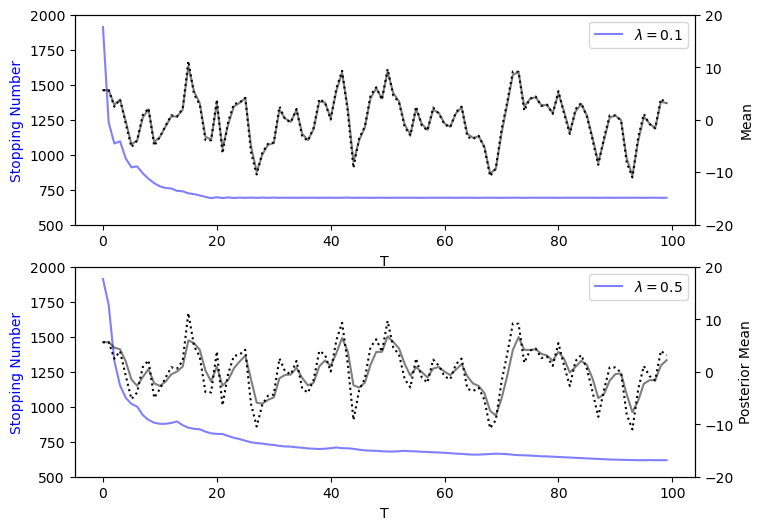

In [196]:
fig, axs = plt.subplots(2,1, figsize=(8,6))

ax_r = axs[0].twinx()
axs[0].plot([int(sr.v) for sr in rsr.rules], c='blue', alpha=0.5, label=r'$\lambda = 0.1$')
axs[0].set_ylabel('Stopping Number', color='blue')
axs[0].set_ylim(500, 2000)

ax_r.plot(means, c='k', linestyle='dotted', label=r'$E(X_T)$')
ax_r.plot([sr.g_hat for sr in rsr.rules], c='k', alpha=0.5, label=r'$\hat{g}_{x_T}$')
ax_r.set_ylabel('Mean')

ax_r.set_ylim([-20,20])
axs[0].set_xlabel('T')
axs[0].legend()

# ---

ax_r = axs[1].twinx()
axs[1].plot([int(sr.v) for sr in rsr_high.rules], c='blue', alpha=0.5, label=r'$\lambda = 0.5$')
axs[1].set_ylabel('Stopping Number', color='blue')
axs[1].set_ylim(500, 2000)

ax_r.plot(means, c='k', linestyle='dotted', label=r'$E(X_T)$')
ax_r.plot([sr.g_hat for sr in rsr_high.rules], c='k', alpha=0.5, label=r'$\hat{g}_{x_T}$')
ax_r.set_ylabel('Posterior Mean')

ax_r.set_ylim([-20,20])
axs[1].set_xlabel('T')
axs[1].legend()